In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/zalando-research/fashionmnist")

Skipping, found downloaded files in "./fashionmnist" (use force=True to force download)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
def read_idx_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()

    num_images = int.from_bytes(data[4:8], 'big')
    rows = int.from_bytes(data[8:12], 'big')
    cols = int.from_bytes(data[12:16], 'big')

    images = np.frombuffer(data, dtype=np.uint8, offset=16)
    images = images.reshape(num_images, 1, rows, cols)

    # 1️⃣ scale to [0,1]
    images = images.astype(np.float32) / 255.0

    # 2️⃣ normalize (Fashion-MNIST stats)
    mean = 0.2860
    std = 0.3530
    images = (images - mean) / std

    return images

def read_idx_labels(filename):
    with open(filename, 'rb') as f:   
        data = f.read()
        
    magic = int.from_bytes(data[0:4], 'big')
    num_labels = int.from_bytes(data[4:8], 'big')
    
    labels = np.frombuffer(data, dtype=np.uint8, offset=8)
    return labels

In [4]:
class Custom_Dataset(Dataset):
    def __init__(self, image , label):
        self.images = torch.tensor(image, dtype = torch.float32)
        self.labels = torch.tensor(label, dtype = torch.long)
        
    def __len__(self):
        return (len(self.images))
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [5]:
test_Ipath=r"/home/namankarki/Naman/3_months_of_data-science/Deep_Learning_Pytorch/cnn/fashionmnist/t10k-images-idx3-ubyte"
test_Lpath=r"/home/namankarki/Naman/3_months_of_data-science/Deep_Learning_Pytorch/cnn/fashionmnist/t10k-labels-idx1-ubyte"
train_Ipath=r"/home/namankarki/Naman/3_months_of_data-science/Deep_Learning_Pytorch/cnn/fashionmnist/train-images-idx3-ubyte"
train_Lpath=r="/home/namankarki/Naman/3_months_of_data-science/Deep_Learning_Pytorch/cnn/fashionmnist/train-labels-idx1-ubyte"



test_images = read_idx_images(test_Ipath)
test_labels = read_idx_labels(test_Lpath)
train_images = read_idx_images(train_Ipath)
train_labels = read_idx_labels(train_Lpath)


In [6]:
training_data = Custom_Dataset(train_images, train_labels)
testing_data = Custom_Dataset(test_images, test_labels)

In [7]:
training_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = 100, shuffle = False)

In [10]:
data = iter(training_dataloader)
img, lbl = (next(data))
print(img.shape)
print(lbl.shape)
print(lbl)

torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([9, 9, 8, 2, 4, 8, 1, 0, 5, 7, 6, 2, 6, 4, 0, 5, 7, 0, 2, 8, 2, 3, 4, 8,
        2, 3, 8, 6, 3, 2, 5, 0, 2, 4, 6, 9, 1, 0, 6, 3, 4, 3, 3, 8, 8, 5, 3, 0,
        5, 0, 1, 1, 5, 9, 3, 5, 5, 0, 5, 5, 0, 8, 6, 9])


In [11]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3),
            nn.ReLU(),
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
model1 = Model1().to(device)

In [12]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,10)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
model2 = Model2().to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer1 = Adam(params=model1.parameters(), lr=0.001)
optimizer2 = Adam(params=model2.parameters(), lr = 0.002, betas=(0.9,0.999), eps=1e-8, weight_decay=1e-4)

In [26]:
# For Model1 (without regularization)
train_losses1, train_accs1 = [], []
val_losses1, val_accs1 = [], []

# For Model2 (with regularization)
train_losses2, train_accs2 = [], []
val_losses2, val_accs2 = [], []


In [27]:
epochs = 20

for epoch in range(epochs):
    train_loss= 0
    train_acc = 0

    
    model1.train()
    for image, label in training_dataloader:
        image = image.to(device)
        label = label.to(device)
        optimizer1.zero_grad()
        logits = model1(image)
        batch_loss = criterion(logits, label)
        batch_loss.backward()
        optimizer1.step()
        train_loss += batch_loss.item() * label.size(0)
        _, preds = torch.max(logits, dim=1)
        train_acc += (preds == label).sum().item()
       
    avg_loss = train_loss / len(training_data)
    avg_acc = train_acc / len(training_data)
    
    train_losses1.append(avg_loss)
    train_accs1.append(avg_acc)

    
    #validation 
    val_loss = 0
    val_acc = 0
    
    model1.eval()
    with torch.no_grad():
        for image , label in testing_dataloader:
            image = image.to(device)
            label = label.to(device)
            logits = model1(image)
            batch_loss = criterion(logits, label)
            val_loss += batch_loss.item() * label.size(0)
            _, preds = torch.max(logits, dim=1)
            val_acc += (preds == label).sum().item()
        
        avg_val_loss = val_loss/len(testing_data)
        avg_val_acc = val_acc / len(testing_data)
        
        val_losses1.append(avg_val_loss)
        val_accs1.append(avg_val_acc)

    
    print(f"Epochs: {epoch+1} / {epochs}")
    print(f"Train Loss: {avg_loss:.4}, Train Acc: {avg_acc:.4}")
    print(f"Test Loss: {avg_val_loss:.4}, Test Acc: {avg_val_acc:.4}")
            

Epochs: 1 / 20
Train Loss: 0.008309, Train Acc: 0.9972
Test Loss: 0.6411, Test Acc: 0.9227
Epochs: 2 / 20
Train Loss: 0.0134, Train Acc: 0.9957
Test Loss: 0.671, Test Acc: 0.9213
Epochs: 3 / 20
Train Loss: 0.006238, Train Acc: 0.9981
Test Loss: 0.6904, Test Acc: 0.9209
Epochs: 4 / 20
Train Loss: 0.01056, Train Acc: 0.9964
Test Loss: 0.7198, Test Acc: 0.9183
Epochs: 5 / 20
Train Loss: 0.01209, Train Acc: 0.9961
Test Loss: 0.6718, Test Acc: 0.9203
Epochs: 6 / 20
Train Loss: 0.01233, Train Acc: 0.9958
Test Loss: 0.7839, Test Acc: 0.9168
Epochs: 7 / 20
Train Loss: 0.009196, Train Acc: 0.9968
Test Loss: 0.7607, Test Acc: 0.9163
Epochs: 8 / 20
Train Loss: 0.009166, Train Acc: 0.997
Test Loss: 0.7735, Test Acc: 0.9191
Epochs: 9 / 20
Train Loss: 0.008041, Train Acc: 0.9972
Test Loss: 0.8372, Test Acc: 0.9153
Epochs: 10 / 20
Train Loss: 0.01003, Train Acc: 0.9969
Test Loss: 0.7725, Test Acc: 0.9172
Epochs: 11 / 20
Train Loss: 0.005457, Train Acc: 0.9981
Test Loss: 0.7763, Test Acc: 0.9125
Epoch

we can clearly see the data is overfitting without regularization in model1

In [28]:
#with regularization
epochs = 20

for epoch in range(epochs):
    train_loss= 0
    train_acc = 0

    
    model1.train()
    for image, label in training_dataloader:
        image = image.to(device)
        label = label.to(device)
        optimizer2.zero_grad()
        logits = model2(image)
        batch_loss = criterion(logits, label)
        batch_loss.backward()
        optimizer2.step()
        train_loss += batch_loss.item() * label.size(0)
        _, preds = torch.max(logits, dim=1)
        train_acc += (preds == label).sum().item()
       
    avg_loss = train_loss / len(training_data)
    avg_acc = train_acc / len(training_data)
    
    train_losses2.append(avg_loss)
    train_accs2.append(avg_acc)

    
    #validation 
    val_loss = 0
    val_acc = 0
    
    model1.eval()
    with torch.no_grad():
        for image , label in testing_dataloader:
            image = image.to(device)
            label = label.to(device)
            logits = model2(image)
            batch_loss = criterion(logits, label)
            val_loss += batch_loss.item() * label.size(0)
            _, preds = torch.max(logits, dim=1)
            val_acc += (preds == label).sum().item()
        
        avg_val_loss = val_loss/len(testing_data)
        avg_val_acc = val_acc / len(testing_data)
        
        val_losses2.append(avg_val_loss)
        val_accs2.append(avg_val_acc)
    
    print(f"Epochs: {epoch+1} / {epochs}")
    print(f"Train Loss: {avg_loss:.4}, Train Acc: {avg_acc:.4}")
    print(f"Test Loss: {avg_val_loss:.4}, Test Acc: {avg_val_acc:.4}")
            

Epochs: 1 / 20
Train Loss: 0.1613, Train Acc: 0.9401
Test Loss: 0.3096, Test Acc: 0.8996
Epochs: 2 / 20
Train Loss: 0.1615, Train Acc: 0.9405
Test Loss: 0.302, Test Acc: 0.9028
Epochs: 3 / 20
Train Loss: 0.1583, Train Acc: 0.9421
Test Loss: 0.3025, Test Acc: 0.9045
Epochs: 4 / 20
Train Loss: 0.1544, Train Acc: 0.9427
Test Loss: 0.2915, Test Acc: 0.9086
Epochs: 5 / 20
Train Loss: 0.155, Train Acc: 0.9421
Test Loss: 0.2906, Test Acc: 0.9072
Epochs: 6 / 20
Train Loss: 0.1518, Train Acc: 0.9441
Test Loss: 0.2949, Test Acc: 0.9008
Epochs: 7 / 20
Train Loss: 0.148, Train Acc: 0.9453
Test Loss: 0.2882, Test Acc: 0.9051
Epochs: 8 / 20
Train Loss: 0.1477, Train Acc: 0.9461
Test Loss: 0.2936, Test Acc: 0.9041
Epochs: 9 / 20
Train Loss: 0.1473, Train Acc: 0.9448
Test Loss: 0.3215, Test Acc: 0.905
Epochs: 10 / 20
Train Loss: 0.1445, Train Acc: 0.9456
Test Loss: 0.307, Test Acc: 0.9047
Epochs: 11 / 20
Train Loss: 0.1439, Train Acc: 0.9474
Test Loss: 0.3097, Test Acc: 0.9043
Epochs: 12 / 20
Train Lo

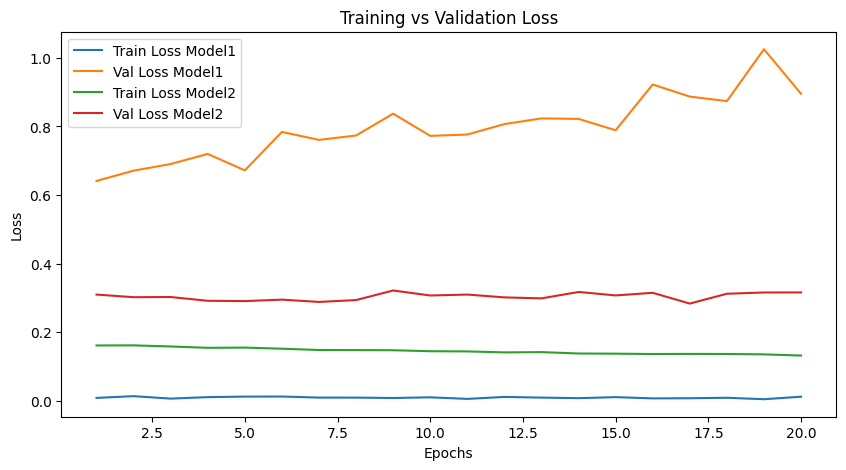

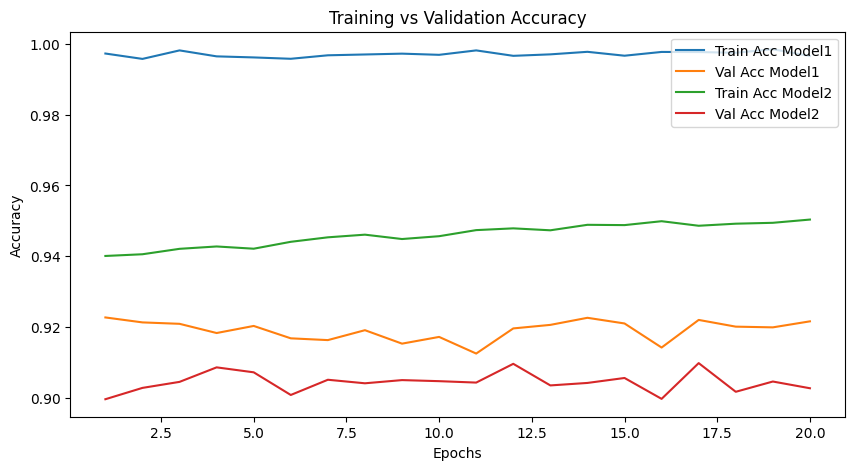

In [29]:
epochs_range = range(1, epochs + 1)

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses1, label="Train Loss Model1")
plt.plot(epochs_range, val_losses1, label="Val Loss Model1")
plt.plot(epochs_range, train_losses2, label="Train Loss Model2")
plt.plot(epochs_range, val_losses2, label="Val Loss Model2")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_accs1, label="Train Acc Model1")
plt.plot(epochs_range, val_accs1, label="Val Acc Model1")
plt.plot(epochs_range, train_accs2, label="Train Acc Model2")
plt.plot(epochs_range, val_accs2, label="Val Acc Model2")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()